## After OPT acquisition, preprocess corrected data.

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
sys.path.insert(1, os.path.abspath(
    'C:\\Users\\David Palecek\\Documents\\Python_projects\\optan\\optan\\src\\optan'))

from data_class import Opt_preprocess, Recon

from tomopy.recon.rotation import find_center_vo
import tomopy as tom

import time
import threading

%load_ext autoreload
%autoreload 2

### Setup

In [2]:

folder = Path(
    'C:\\Users\\David Palecek\\Documents\\UAlg\\my_opt\\Data\\230919-13-57-53_corr_int')
depth = np.int16
format = 'tiff'
binning = 2

In [8]:
# load data
data = Opt_preprocess(folder, depth=depth, format=format)
data.load_folder(mode='simple')
print('data shape:', data.data.shape)

data shape: (208, 2048, 1536)


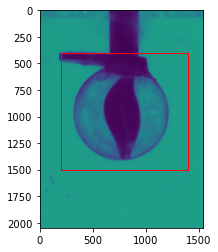

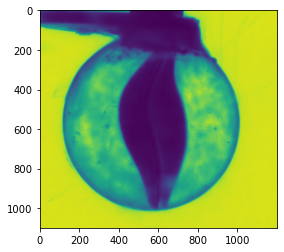

In [9]:
## I need to select the rectangle
x, y = 200, 400
w, h = 1200, 1100

fig, ax = plt.subplots()
ax.imshow(data.data[0])
r = patches.Rectangle((x, y), w, h,
                  linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(r)
plt.show()

fig, ax = plt.subplots()
ax.imshow(data.data[0][y:y+h, x:x+w])
plt.show()


### Cutting based on x, y, w, h

In [10]:
data.data = data.data[39:129, y:y+h, x:x+w]
data.n_steps = data.data.shape[0]

In [11]:
def binx(idx, bin_factor, arr_in, arr_out):
    arr_out[idx] = arr_in[idx].reshape(
                                arr_in.shape[1]//bin_factor,
                                bin_factor,
                                arr_in.shape[2]//bin_factor,
                                bin_factor,
                            ).mean(3).mean(1)
    
def recon_thread(idx, theta, center, arr, arr_out):
    arr_out[idx] = tom.recon(arr[:, idx:idx+1, :],
                             theta,
                             center=center,
                             sinogram_order=False,
                             algorithm='art').squeeze()

In [12]:
binned = np.zeros((data.data.shape[0],
                  data.data.shape[1]//binning,
                  data.data.shape[2]//binning), dtype=np.int16)

beg = time.perf_counter()
for i in range(data.n_steps):
    threadProcess = threading.Thread(
                        name='simplethread',
                        target=binx,
                        args=[i, binning, data.data, binned],
                    )
    threadProcess.daemon = True
    threadProcess.start()
end = time.perf_counter()
print('Binning took:', np.round(end-beg, 2), 's')

data.data = binned
print(data.data.shape)

Binning took: 0.47 s
(90, 550, 600)


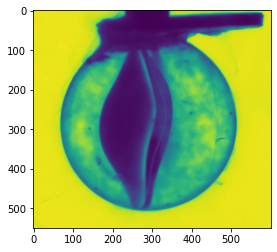

In [13]:
fig, ax = plt.subplots()
ax.imshow(data.data[0])
plt.show()

center found at 292.75
(1, 600, 600)


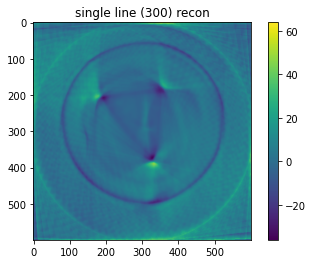

In [14]:
# single line reconstruction
recon = Recon(data)
recon.recon_single(300)

print(recon.recon.shape)

plt.imshow(recon.recon[0])
plt.colorbar()
plt.title(f'single line ({recon.line}) recon')
plt.show()

In [15]:
cs = []
for i in range(0, data.data.shape[1], 100):
    recon.line = i
    cs.append(recon.find_center_single())
    print(i, end='\r')


center found at 289.0
center found at 292.5
center found at 293.75
center found at 292.75
center found at 292.0
center found at 289.0


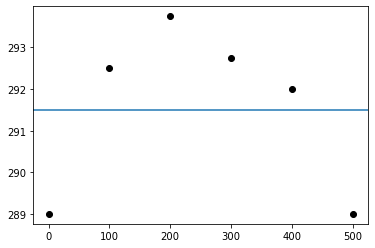

In [16]:
plt.plot(range(0, data.data.shape[1], 100),
         cs, 'ko')
plt.axhline(np.mean(cs))
plt.show()

### Now full reconstruction

In [17]:
print('Running FULL reconstruction')
ibeg, iend = 0, data.data.shape[1]
beg = time.perf_counter()
dim = iend - ibeg
data_recon = np.zeros((data.data.shape[1], *recon.recon.squeeze().shape))
threads = [None] * dim

for i in range(dim):
    print(i, end='\r')
    threads[i] = threading.Thread(target=recon_thread,
                                    args=[i+ibeg, recon.theta, np.mean(cs),
                                          recon.data.data, data_recon])
    threads[i].start()

for i in range(len(threads)):
    threads[i].join()
end = time.perf_counter()
print('Reconstruction took:', np.round(end-beg, 2), 's')

Running FULL reconstruction
Reconstruction took: 57.56 s


In [18]:
# rescaling and saving as uint8
mx, mn = np.amax(data_recon), np.amin(data_recon)
print(mx, mn)
if mn < 0:
    print('rescaling', mn, mx)
    recon_int = np.asarray((data_recon - mn)*2**12/(mx-mn), dtype=np.uint16)

print('Saving')
to_save = recon_int[ibeg:iend]
np.save('recon4x_cont', to_save)

78.2567367553711 -48.6810417175293
rescaling -48.6810417175293 78.2567367553711
Saving
